In [37]:
import statsmodels.api as sm # съдържа методи за линейна регресия, логистична регресия и др.
import statsmodels.formula.api as smf
import statsmodels.graphics.api as smg
import patsy # не е нужно да внасяме (съдържа се в statsmodels), но за демонстрация; може да се ползва напр. със scikit-learn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Sepal.Length  150 non-null    float64
 1   Sepal.Width   150 non-null    float64
 2   Petal.Length  150 non-null    float64
 3   Petal.Width   150 non-null    float64
 4   Species       150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB
Optimization terminated successfully.
         Current function value: 0.102818
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:                Species   No. Observations:                  100
Model:                          Logit   Df Residuals:                       97
Method:                           MLE   Df Model:                            2
Date:                Mon, 20 Dec 2021   Pseudo R-squ.:                  0.8517
Time:                        00:00:34   Log-L

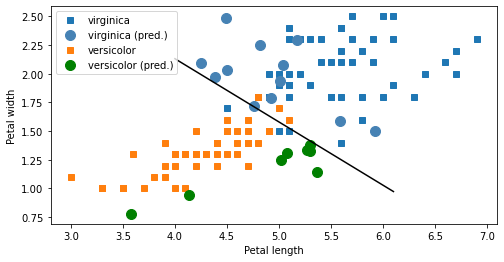

In [26]:
### разглеждаме Regression with discrete dependent variables (for example, binary outcomes). Може да използваме логистичното
# уравнение, cdf на нормалното разпределение или друго; map x от (-inf, +inf) към p от [0, 1]. Повече информация на f.351
### Тук ще използваме 

# първо ще свалим dataset чрез функцията sm.datasets.get_rdataset

df = sm.datasets.get_rdataset("iris").data # dataset с размери на листа на цветове ириси от различни видове
df.info() # показва какви променливи има в dataset

df.Species.unique() # за да видим колко unique types of species са в колоната Species - има 3 вида ириси

# разглеждаме регресия с два изхода и избираме virginica и versicolor
df_subset = df[(df.Species == "versicolor") | (df.Species == "virginica")].copy() # за удобство създаваме subset от избраните

df_subset.Species = df_subset.Species.map({"versicolor": 1, "virginica": 0}) # map-ваме 1 и 0, за да имаме бинарна променлива
df_subset.rename(columns={"Sepal.Length": "Sepal_Length", "Sepal.Width": "Sepal_Width", "Petal.Length": "Petal_Length",
                          "Petal.Width": "Petal_Width"}, inplace=True) # преименуваме колоните с '_' вместо с '.', иначе грешки

df_subset.head(5)

### Правим логистичен модел, в който petal_length и petal_width са независими променливи. Използваме класа smf.logit и Patsy
model = smf.logit("Species ~ Petal_Length + Petal_Width", data=df_subset) # името на модела е model (лошо решение, но туй то...)

## Прилагаме модела (който досега е само израз) към нашите данни. Праговата стойност е 0,5
result = model.fit()

print(result.summary()) # обобщение на изчислените параметри на модела

print(result.get_margeff().summary()) # the marginal effect на всяка от explanatory variables в модела

### Когато сме доволни от модела, можем да предскажем стойността на response var при други стойности на explanatory var
# Първо ще си направи нови данни (от други стойности на explanatory var), уж сме ги получили от някъде
df_new = pd.DataFrame({"Petal_Length": np.random.randn(20)*0.5 + 5, "Petal_Width": np.random.randn(20)*0.5 + 1.7})

df_new["P-Species"] = result.predict(df_new) # тук използваме метода predict върху новите данни за размера на листенцата
df_new["P-Species"].head(3) # ред с вероятности for each observation to correspond to the response y =1

# сравнявайки тези вероятности с праговата стойност 0.5, можем да предскажем binary value of the response variable
df_new["Species"] = (df_new["P-Species"] > 0.5).astype(int) # нова колона в df_new
df_new["Species"].head(10)

# intercept и наклонът на правата, разделяща точките с y = 0 and y =1  (в равнината Petal_Width и Petal_Length), могат да бъдат
# намерени от параметрите на фитнатия model
params = result.params # пак лош избор на име...
alpha0 = -params['Intercept']/params['Petal_Width']
alpha1 = -params['Petal_Length']/params['Petal_Width']
print(params)


### Представяме графично (scatter plot) fitted (squares) и predicted (circles) данни
fig, ax = plt.subplots(1, 1, figsize=(8, 4))

# species virginica
ax.plot(df_subset[df_subset.Species == 0].Petal_Length.values, 
        df_subset[df_subset.Species == 0].Petal_Width.values, 's', label='virginica')
ax.plot(df_new[df_new.Species == 0].Petal_Length.values, df_new[df_new.Species == 0].Petal_Width.values,
        'o', markersize=10, color="steelblue", label='virginica (pred.)')

 # species versicolor
ax.plot(df_subset[df_subset.Species == 1].Petal_Length.values, 
        df_subset[df_subset.Species == 1].Petal_Width.values, 's', label='versicolor')
ax.plot(df_new[df_new.Species == 1].Petal_Length.values, df_new[df_new.Species == 1].Petal_Width.values, 
        'o', markersize=10, color="green", label='versicolor (pred.)')

# boundary line
_x = np.array([4.0, 6.1])
ax.plot(_x, alpha0 + alpha1 * _x, 'k')
ax.set_xlabel('Petal length')
ax.set_ylabel('Petal width')
ax.legend()

Optimization terminated successfully.
         Current function value: 2.168457
         Iterations 1
                          Poisson Regression Results                          
Dep. Variable:                  value   No. Observations:                  100
Model:                        Poisson   Df Residuals:                       99
Method:                           MLE   Df Model:                            0
Date:                Mon, 20 Dec 2021   Pseudo R-squ.:                   0.000
Time:                        23:39:00   Log-Likelihood:                -216.85
converged:                       True   LL-Null:                       -216.85
Covariance Type:            nonrobust   LLR p-value:                       nan
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.1314      0.057     19.920      0.000       1.020       1.243


<ipython-input-52-24020eb6ef34>:42: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  v, k = np.histogram(df.values, bins=12, range=(0, 12), normed=True)


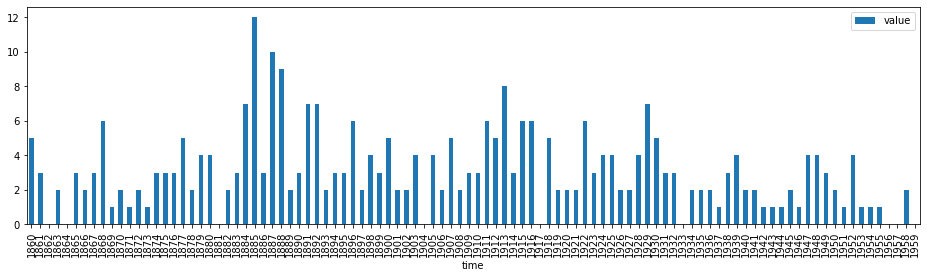

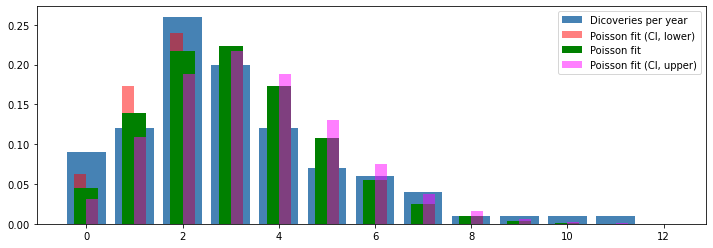

In [52]:
### Poisson model: когато response variable е success count за много опити, всеки от които е с много малка вероятност за успех.
# if a collection of random points in some space forms a Poisson process (напр. произволно избрани точки върху равнина 
# или върху права), then the number of points in a region of finite size is a random variable with a Poisson distribution.

# За да покажем как се фитват данни към поасонов модел, ще разгледаме още едно примерно dataset - Discoveries, което съдържа
# counts на значими научни открития в периода 1860 - 1959 г. Поради естеството на данните те са разпределени поасоново.

dataset = sm.datasets.get_rdataset("discoveries")
# dataset.data.head(6) # виждаме, че има някакъв естествен индекс числа, но искаме да го сменим с година
df = dataset.data.set_index("time") # новият стар dataset с друг индекс
df.head(10).T # за да е по-удобно за представяне, иначе ще стане 10 реда с по 2 данни на ред

# Можем да направим bar graph на броя открития за всяка година
fig, ax = plt.subplots(1, 1, figsize=(16, 4))
df.plot(kind='bar', ax=ax) #

# Изглежда, че броят важни открития за година е горе-долу константа, въпреки че се забелязва лек спад в късните кодини. Все пак
# хипотезата, че разпределението е поасоново не е за пренебрегване. За да изследваме това, можем да фитнем данните към Poisson
# процес, използвайки smf.poisson класа Patsy "discoveries ~ 1", което означава, че моделираме the discoveries variable 
# единствено чрез an intercept coefficient (the Poisson distribution parameter).

model = smf.poisson("value ~ 1", data=df) # отново наричаме модела си model и value е броят на откритията
result = model.fit() # след като го създадем, извикваме метода fit, за да фитнем данните
print(result.summary()) # показва обобщение и някои statistics

result.conf_int() # доверителен интервал за параметрите на модела - тук параметърът е само един

result.params # това е стойността на intercept, който е свързан с ламбда параметъра от поасоновото разпределение посредством
lmbda = np.exp(result.params) # това е ламбда от поасоновото разпределение

# Сега можем да сравним хистограмата на наблюдаваните counts с теоретични counts, получени от поасоново разпределена
# случайна величина от SciPy stats library.
X = stats.poisson(lmbda)

# За да оценим фитването на данните към Poisson distribution, създаваме rand променливи за долната и горната граница на 
#доверителния интервал за intercept (вж. по-горе)
X_ci_l = stats.poisson(np.exp(result.conf_int().values)[0, 0]) # lower
X_ci_u = stats.poisson(np.exp(result.conf_int().values)[0, 1]) # upper

# Правим хистограма на наблюдаваните counts с теоретична probability mass functions за поасоновите разпределения, 
# съответстващи на the fitted model parameter and its confidence intervals.
v, k = np.histogram(df.values, bins=12, range=(0, 12), normed=True)
fig, ax = plt.subplots(1, 1, figsize=(12, 4))

ax.bar(k[:-1], v, color="steelblue", align='center', label='Dicoveries per year')
ax.bar(k-0.125, X_ci_l.pmf(k), color="red", alpha=0.5, align='center', width=0.25, label='Poisson fit (CI, lower)')
ax.bar(k, X.pmf(k), color="green", align='center', width=0.5, label='Poisson fit')
ax.bar(k+0.125, X_ci_u.pmf(k), color="magenta", alpha=0.5, align='center', width=0.25, label='Poisson fit (CI, upper)')
ax.legend()

#The resultindicates that the dataset of great discoveries are not well described by
# a Poisson process, since the agreement between Poisson probability mass function and the observed counts
# deviates significantly. The hypothesis that the great discoveries per year are a Poisson process must therefore
# be rejected. A failure to fit a model to a given dataset is of course a natural part of statistical modeling process,
# and although the dataset turned out not to be Poisson distributed (perhaps because years with a large
# and small number of great discovers tend to be clustered together), we still have gained insight by the
# failed attempt to model it as such. Because of the correlations between the number of discoveries at any
# given year and its recent past, a time-series analysis could be a better approach.